# TAREA 1 - BITWISE OPERATORS

## Introducción

Toda imagen se puede ver como una matriz de x ancho por y alto. Dentro de esta matriz tenemos x*y elementos, en el caso de una imagen, estos son pixeles. 
Los pixeles a su vez, pueden ser vistos como un arreglo de 3 numeros tomando cada uno un valor entre el 0 y el 255. 
Asimismo cada numero está representado por un byte, un conjunto de 8 bits teniendo un valor de 0 o 1.
Nuestro objetivo en este caso es aprovecharse de esto para ocultar mensajes dentro de una imagen. 

¿Como podemos ocultar un mensaje compuesto por letras dentro de una imagen? 
Nos aprovecharemos de la representación ASCII que tiene cada caractér.

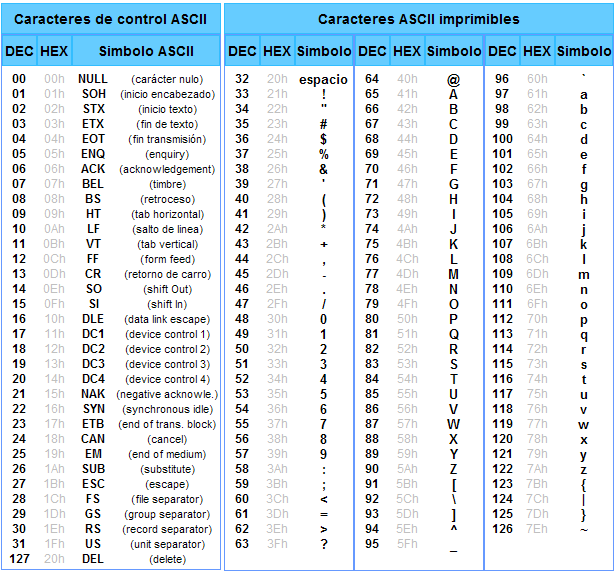

Aquí podemos observar que todo caracter tiene asignado un numero para representarlo, por ende, podemos tratar cada caracter como una cadena de números. Una vez que sabemos como pasar de caracteres a números, podemos entonces pasar de numeros a binario y así obtener los bits asociados a cada letra de nuestro mensaje. Usaremos entonces este proceso de transformación de manera de esconder bits del mensaje dentro de los bytes de la imagen. Esto es lograble al alterar los bits de los canales de colores de cada pixel, aquí lo haremos de tres maneras distintas, ya sea dividiendo los bytes en 3, 6 u 8 partes. En el caso de la división por 3, almacenaremos 3 bits por pixel, es decir, uno por canal. Para la división por 6 serán 6 bits por pixel, es decir, 2 por canal y en la división por 8 almacenaremos el byte completo en uno de los canales del pixel, en este caso, reemplazaremos el canal GREEN.

### Código

Aquí descargamos una imagen desde una URL específica y la abrimos para su posterior manipulación

In [2]:
import urllib.request as ureq

url = "https://images2-mega.cdn.mdstrm.com/mega/2024/08/30/felipe-camiroaga_177558_2_66d25cbb2640f.jpeg?d=950x535"
hdr = {'User-Agent':'Mozilla/5.0'}
req = ureq.Request(url, headers = hdr)
foto = ureq.urlopen(req)

import PIL.Image as img

f = img.open(foto)

### Funciones

Tenemos primero la función text_to_bin donde definimos un caracter de termino que nos indicara cuando dejar de decodificar una imagen además de traducir el texto original a la representación ASCII de cada letra y posteriormente traspasando los números a binario.

In [3]:
def text_to_bin(text):
    #Definimos el caracter de termino para la recuperacion del mensaje
    text += '\0'  
    return ''.join(format(ord(c), '08b') for c in text)

Luego tenemos las funciones para ocultar los bits, una para cada división. Para cada una se obtienenen las dimensiones de la imagen a editar y la recorremos pixel a pixel, aquí obtenemos los valores de cada canal RGB y para la división en 3 y 6 partes, forzamos que los último o los 2 últimos bit sean 0 con uno o dos right shifts >> seguido de uno o dos left shift << respectivamente. Luego, utilizamos el operador lógico OR (|) para editar estos bits. Guardamos el nuevo valor numérico del color y lo actualizamos en la imagen con la función putpixel(). Con la ayuda de un contador, vamos avanzando en la cadena de texto con los bits a insertar hasta que se acabe.

In [4]:
#Algoritmo para descomponer cada byte en 3, es decir, una letra se esconde en 3 pixeles
def ocultar_bits3(img, bin_msg):
    #sacamos dimensiones de la imagen
    w, h = img.size
    cont = 0  # índice en del mensaje en binario
    
    #Recorremos la imagen
    for i in range(w):
        for j in range(h):
            if cont >= len(bin_msg):
                return img  #Se acabó el mensaje y retorno la imagen 
            

            #Sacamos los 3 valores del pixel
            r, g, b = img.getpixel((i, j))
            #Lista donde vamos a guardar los nuevos valores de las componentes del pixel
            nuevos = []

            for color in (r, g, b):
                if cont < len(bin_msg):
                    #Forzamos a que el último bit sea 0
                    color >>= 1
                    color <<= 1
                    #Insertamos el nuevo bit
                    color |= int(bin_msg[cont])
                    cont += 1
                nuevos.append(color)
            #Volvemos a insertar el pixel en su posicion con el nuevo color
            img.putpixel((i, j), tuple(nuevos))
    return img


#Algoritmo para descomponer cada byte en 6, es decir, una letra se esconde en 2 pixeles
def ocultar_bits6(img, bin_msg):
    #sacamos dimensiones de la imagen
    w, h = img.size
    cont = 0  # índice en del mensaje en binario
    largo = len(bin_msg)
    
    #Recorremos la imagen
    for i in range(w):
        for j in range(h):
            if cont >= largo:
                return img  #Se acabó el mensaje y retorno la imagen 
            

            #Sacamos los 3 valores del pixel
            r, g, b = img.getpixel((i, j))
            #Lista donde vamos a guardar los nuevos valores de las componentes del pixel
            nuevos = []

            for color in (r, g, b):
                #Como forzamos el largo de cada letra a 8 y vamos sacando los bits de 2 en 2, no existe la posibilidad de que quede 1 bit por lo que no es necesario hacer más casos
                if cont + 1 < largo:
                    bit1 = int(bin_msg[cont])
                    bit2 = int(bin_msg[cont+1])
                    bits = (bit1 << 1) | bit2 #Le agregamos un 0 al primer bit (00 o 10) y le agregamos el segundo bit


                #Forzamos a que el los ultimos 2 bits sean 0
                color >>= 2
                color <<= 2
                #Insertamos el nuevo bit
                color |= bits
                cont += 2
                nuevos.append(color)
            #Volvemos a insertar el pixel en su posicion con el nuevo color
            img.putpixel((i, j), tuple(nuevos))
    return img

Para la división en 8, tomamos directamente el canal GREEN, lo llevamos a 0 haciendo un XOR (^) consigo mismo y luego editamos su valor con el deseado con un OR (|) entre el canal y el byte deseado

In [5]:
#Algoritmo para descomponer cada byte en 8, es decir, una letra se esconde en 1 pixel
def ocultar_bits8(img, bin_msg):
    #sacamos dimensiones de la imagen
    w, h = img.size
    cont = 0  # índice en del mensaje en binario
    largo = len(bin_msg)
    
    #Recorremos la imagen
    for i in range(w):
        for j in range(h):

            if cont >= largo:
                return img  #Se acabó el mensaje y retorno la imagen 

            #Sacamos los 3 valores del pixel
            r, g, b = img.getpixel((i, j))
            #Reemplazamos el valor de alguna de las componentes del pixel
            g = g ^ g  # deja g en 0
            g = g | int(bin_msg[cont:cont+8], 2)  # metemos 8 bits con OR
            #Volvemos a insertar el pixel en su posicion con el nuevo color
            img.putpixel((i, j), (r, g, b))
            cont += 8
    return img

Aquí tenemos la función encargada de hacer el proceso inverso, Dada una imagen y un parámetro division que indica el esquema de ocultamiento utilizado:

division = 3 → se recupera 1 bit por canal (RGB), es decir, 3 bits por píxel.

division = 6 → se recuperan 2 bits por canal, es decir, 6 bits por píxel.

division = 8 → se recupera el byte completo (8 bits) del canal G por píxel.

El procedimiento consiste en recorrer cada píxel de la imagen, aplicar una máscara bitwise sobre cada canal relevante y reconstruir los bits del mensaje en una cadena binaria.
Cada vez que se acumulan 8 bits, se convierten a un carácter ASCII, formando así el mensaje original.
El proceso finaliza al encontrar el carácter nulo '\0', que actúa como marcador de término del mensaje.

In [6]:
def recuperar_bits(img, division):
    # Sacamos las dimensiones de la foto
    w, h = img.size
    # String donde almacenaremos la cadena resultante
    resultado = ""
    # Texto con bits extraidos de la foto
    extraidos = ""

    # Determinar máscara y ancho (bits por canal) según el esquema usado
    if division == 3:          # 3 bits por píxel, 1 bit por canal
        mascara = 1 #00000001 en binario
        ancho = 1
    elif division == 6:        # 6 bits por píxel, 2 bits por canal
        mascara = 3 #00000011 en binario
        ancho = 2
    elif division == 8:        # 8 bits por píxel, 1 byte completo en canal G
        mascara = 255 #11111111 en binario
        ancho = 8
    else:                      # Manejo de error -> por defecto 1 bit por canal
        mascara = 1
        ancho = 1

    # Recorremos la imagen 
    for i in range(w):
        for j in range(h):
            # Obtenemos los valores de la imagen
            r, g, b = img.getpixel((i, j))

            # Aquí va la corrección: usar solo G si division == 8
            canales = (g,) if division == 8 else (r, g, b)
            for color in canales:
                # Extraer los últimos 'ancho' bits 
                valor = color & mascara

                # Pasar a binario rellenando a 'ancho' bits 
                pedacito = format(valor, f'0{ancho}b')

                # Acumular bits
                extraidos += pedacito

                # Cada 8 bits formamos un byte y lo convertimos a caracter
                while len(extraidos) >= 8:
                    byte = extraidos[:8]
                    extraidos = extraidos[8:]
                    letra = chr(int(byte, 2))
                    if letra == '\0':  # caracter de fin
                        return resultado
                    resultado += letra

    return resultado

En esta etapa se procede a aplicar los métodos de inserción y recuperación del mensaje en la imagen utilizando distintos esquemas de modificación de bits.
El objetivo es observar cómo varía la calidad visual de la imagen resultante y verificar si el mensaje oculto puede recuperarse íntegramente.
Para ello, se generarán y analizarán tres casos:

1.- Ocultamiento con 1 bit por canal (R, G y B).

2.- Ocultamiento con 2 bits por canal (R, G y B).

3.- Ocultamiento con 1 byte completo en el canal GREEN.

De esta manera, se comparan las ventajas y desventajas de cada esquema en términos de imperceptibilidad, capacidad de almacenamiento y robustez de recuperación.

Imagen original


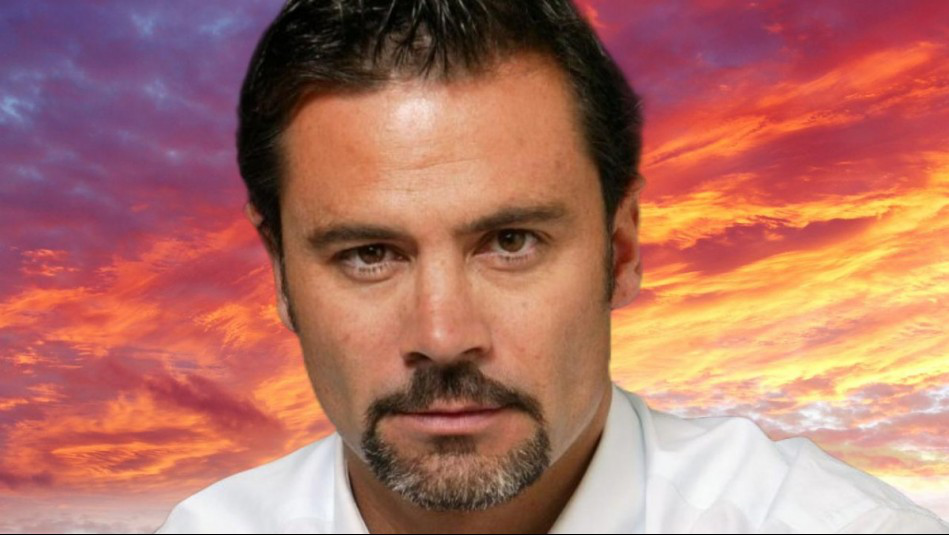

Imagen con mensaje oculto con 1 bit por canal


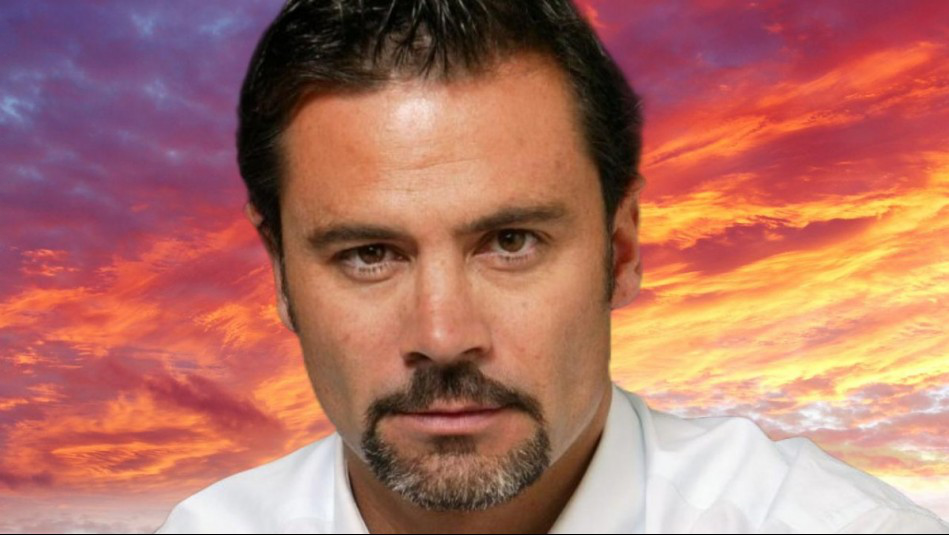

Imagen con mensaje oculto con 2 bit por canal


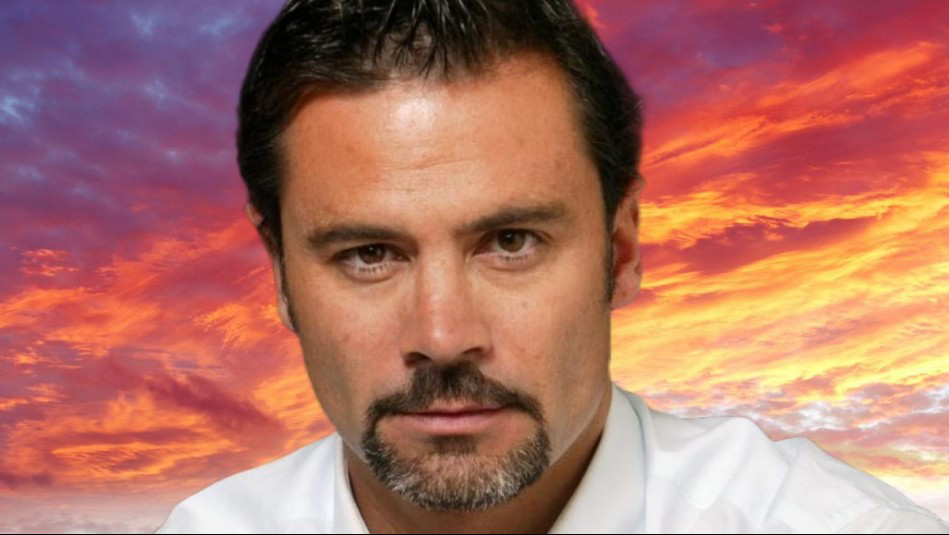

Imagen con mensaje oculto con 1 byte en GREEN


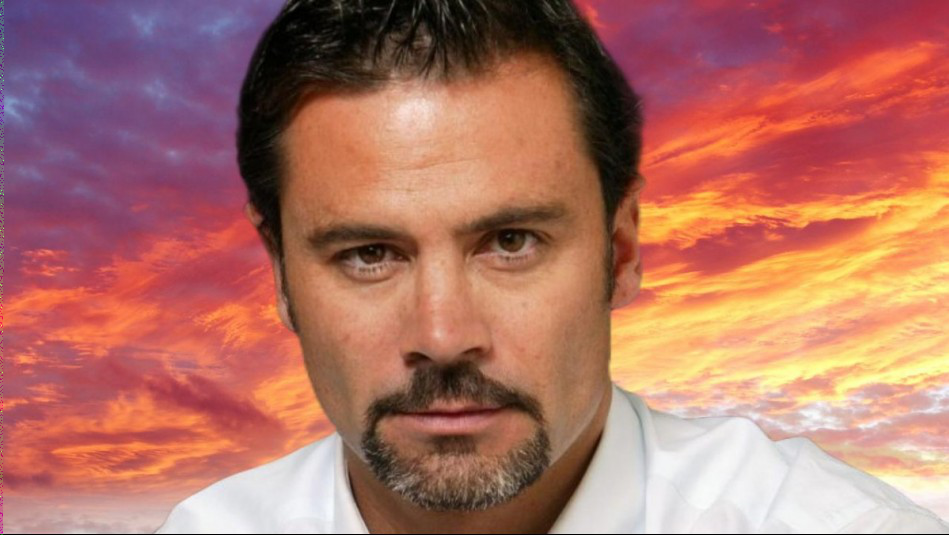

A Felipe, Halcón de los Cielos

En la aurora tibia de la memoria,
tu nombre aún resplandece, Felipe,
como un faro que no se apaga
aunque el viento del tiempo sople incansable.

Tus alas de halcón, desplegadas en Chicureo,
eran metáfora y presagio:
un espíritu libre,
un hombre que jamás se conformó
con mirar la vida desde el suelo.

Brillaste en pantallas que se hicieron hogar,
no solo por tu sonrisa franca,
sino porque en tus ojos se adivinaba
esa transparencia que rara vez
viste la televisión.
Eras cercano,
como el amigo de las mañanas,
como el hermano que llega a conversar
sin pedir permiso.

El pueblo entero sintió tu partida
como quien pierde a un familiar,
un silencio cayó en las casas
cuando el mar del archipiélago
se guardó tu voz,
y Chile, entero y estremecido,
te lloró bajo una misma bandera.

Eras más que un conductor,
más que un actor, más que un rostro:
eras un puente,
un alma sensible que tocaba las fibras
de quienes veían en ti
un reflejo de ternura y valentía.

Tus broma

In [12]:
import urllib.request as ureq

url = "https://images2-mega.cdn.mdstrm.com/mega/2024/08/30/felipe-camiroaga_177558_2_66d25cbb2640f.jpeg?d=950x535"
hdr = {'User-Agent':'Mozilla/5.0'}
req = ureq.Request(url, headers = hdr)
foto = ureq.urlopen(req)

import PIL.Image as img

f = img.open(foto)

resultado = ""

#En caso de querer probar otra cosa
#msg = str(input("Escriba el mensaje a ocultar"))

#Mensaje sugerido:

poema = """A Felipe, Halcón de los Cielos

En la aurora tibia de la memoria,
tu nombre aún resplandece, Felipe,
como un faro que no se apaga
aunque el viento del tiempo sople incansable.

Tus alas de halcón, desplegadas en Chicureo,
eran metáfora y presagio:
un espíritu libre,
un hombre que jamás se conformó
con mirar la vida desde el suelo.

Brillaste en pantallas que se hicieron hogar,
no solo por tu sonrisa franca,
sino porque en tus ojos se adivinaba
esa transparencia que rara vez
viste la televisión.
Eras cercano,
como el amigo de las mañanas,
como el hermano que llega a conversar
sin pedir permiso.

El pueblo entero sintió tu partida
como quien pierde a un familiar,
un silencio cayó en las casas
cuando el mar del archipiélago
se guardó tu voz,
y Chile, entero y estremecido,
te lloró bajo una misma bandera.

Eras más que un conductor,
más que un actor, más que un rostro:
eras un puente,
un alma sensible que tocaba las fibras
de quienes veían en ti
un reflejo de ternura y valentía.

Tus bromas, tus gestos,
esa mezcla de sencillez y nobleza
siguen intactos en el recuerdo,
y en cada risa que compartiste
nació una semilla de afecto
que aún florece en quienes te evocan.

Hoy, cuando miramos el cielo nocturno,
muchos buscan en las estrellas
ese destello que anuncie tu vuelo,
ese resplandor que diga
que no hay ausencia verdadera,
sino un cambio de paisaje
en la misma eternidad.

Felipe, halcón de los cielos,
tu partida no es un adiós:
es un eco que se prolonga,
es un abrazo suspendido,
es la certeza de que tu luz,
aunque apagada en lo visible,
sigue viva en lo invisible.

Descansa en paz,
querido conductor de almas,
eterno compañero de mañanas;
que la brisa de Juan Fernández
sea canto y arrullo,
y que la patria agradecida
te nombre siempre con cariño.

Porque mientras haya un corazón chileno
que recuerde tu risa,
tú seguirás volando,
alto, libre, infinito.
"""

bin_text = text_to_bin(poema)
text_len = len(bin_text)

print("Imagen original")
display(f)

oculto1 = ocultar_bits3(f, bin_text)
print("Imagen con mensaje oculto con 1 bit por canal")
display(oculto1)

oculto2 = ocultar_bits6(f, bin_text)
print("Imagen con mensaje oculto con 2 bit por canal")
display(oculto2)

oculto3 = ocultar_bits8(f, bin_text)
print("Imagen con mensaje oculto con 1 byte en GREEN")
display(oculto3)

resultado1 = recuperar_bits(oculto1, 3)
resultado2 = recuperar_bits(oculto2, 6)
resultado3 = recuperar_bits(oculto3, 8)

print(poema, resultado1, resultado2, resultado3)

## CONCLUSIÓN

Los resultados obtenidos muestran que la técnica de modificación de bits permite ocultar y recuperar mensajes de manera eficaz en imágenes digitales.

El esquema de 1 bit por canal se presenta como la opción más equilibrada: ofrece suficiente capacidad para mensajes de texto y mantiene una calidad visual prácticamente inalterada.

El esquema de 2 bits por canal incrementa notablemente la capacidad, aunque introduce ligeras alteraciones perceptibles al comparar las imágenes.

Finalmente, el método de 1 byte en el canal verde maximiza la capacidad de ocultamiento, pero a costa de una pérdida visual significativa, lo que lo hace poco recomendable cuando se requiere discreción.

En síntesis, se confirma que existe un compromiso entre capacidad y calidad visual, siendo el uso de 1 bit por canal la alternativa más adecuada para un balance eficiente entre ambos criterios.